# Install extra packages

In [56]:
!pip install -q -U tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 23.6 MB/s eta 0:00:00


# Import Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!rsync -avzP /content/drive/MyDrive/datasets/kaggling/pfam/pfam.zip . 
!unzip -q pfam.zip

Mounted at /content/drive
sending incremental file list
pfam.zip
    517,047,246 100%   26.77MB/s    0:00:18 (xfr#1, to-chk=0/1)

sent 517,323,336 bytes  received 35 bytes  25,235,286.39 bytes/sec
total size is 517,047,246  speedup is 1.00


# Imports

In [73]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
import tensorflow as tf
from functools import partial 

import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
import seaborn
import os
import gc

# Inspect dataset

In [7]:
data_dirpath = "random_split"
print('Available dataset partitions: ', os.listdir(data_dirpath))

Available dataset partitions:  ['dev', 'train', 'random_split', 'test']


In [35]:
def read_all_shards(partition='dev', data_dir = data_dirpath):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    
    return pd.concat(shards)

def read_all_data_initial():
  global train, test, dev, all_train_ds_size, all_test_ds_size, all_dev_ds_size

  test = read_all_shards('test')
  dev = read_all_shards('dev')
  train = read_all_shards('train')

  partitions = {'test': test, 'dev': dev, 'train': train}
  for name, df in partitions.items():
      print('Dataset partition "%s" has %d sequences' % (name, len(df)))

  all_train_ds_size = len(train)
  all_test_ds_size = len(test)
  all_dev_ds_size = len(dev)

  train.reset_index(inplace=True, drop=True)
  dev.reset_index(inplace=True, drop=True)
  test.reset_index(inplace=True, drop=True)

read_all_data_initial()

Dataset partition "test" has 126171 sequences
Dataset partition "dev" has 126171 sequences
Dataset partition "train" has 1086741 sequences


In [36]:
def plot_counts(data):

    counter = Counter(data['family_accession'])
    print(f"how many labels : {len(counter)}")
    
    datasetSize = len(data)
    xs = []
    x_labels = []
    ys = []

    t = 0
    cumulative = []

    for i,(x, y) in  enumerate(counter.most_common()):
        xs.append(i)
        x_labels.append(x)
        ys.append(y)
        t += y / datasetSize
        cumulative.append(t)

    plt.figure(figsize=(16 ,6))
    plt.subplot(1, 2, 1)
    plt.plot(xs, ys)
    plt.yscale("log")

    plt.subplot(1, 2, 2)
    plt.plot(xs, cumulative)
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    plt.show()
    return cumulative


how many labels : 17929


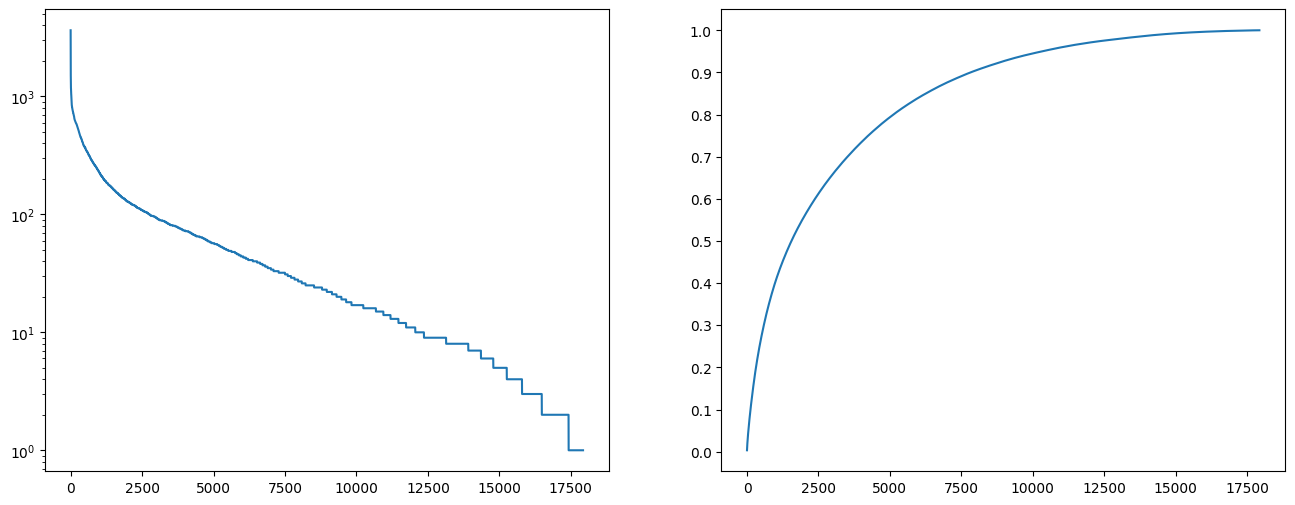

In [37]:
cumulative = plot_counts(train)

In [42]:
n_families_of_interest = 3000

print(f"{n_families_of_interest} classes is {100 * round( cumulative[n_families_of_interest-1],3)} portion of training data")

3000 classes is 65.9 portion of training data


# Create the Dataset

how many labels : 3000


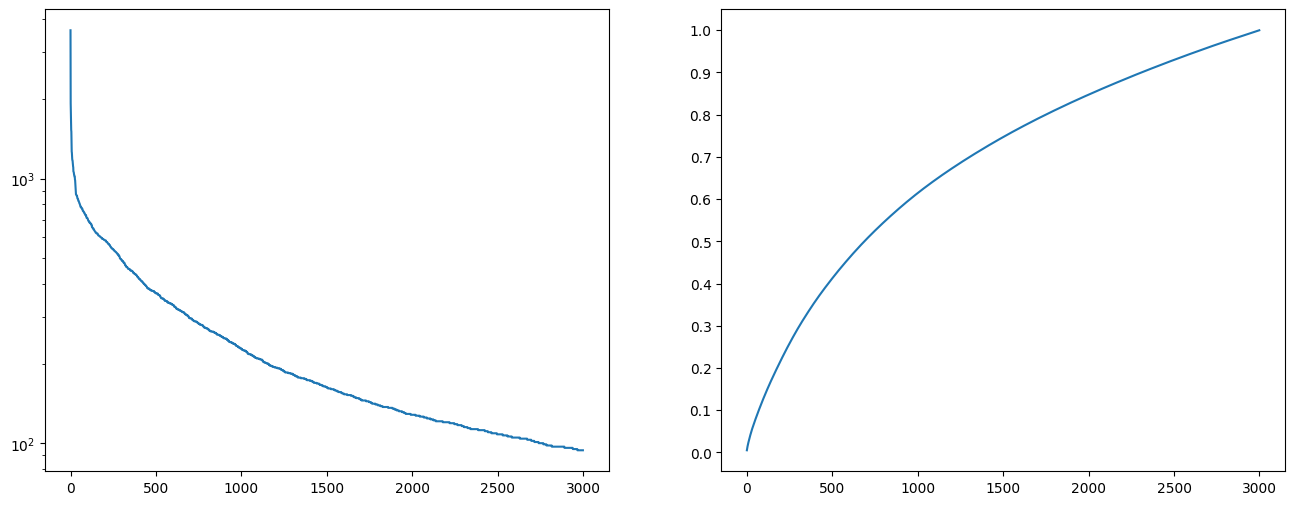

In [44]:
familiesOfInterest = train.family_accession.value_counts()[:n_families_of_interest]

mask = train.family_accession.isin(familiesOfInterest.index.values)
train = train.loc[mask,:]

mask = dev.family_accession.isin(familiesOfInterest.index.values)
dev = dev.loc[mask,:]

mask = test.family_accession.isin(familiesOfInterest.index.values)
test = test.loc[mask,:]

cumulative_split = plot_counts(train)

In [45]:
train_seq = train['sequence']
dev_seq = dev['sequence']
test_seq = test['sequence']

In [46]:
train_sentences = train_seq.apply(lambda seq: [aa for aa in seq])
validation_sentences = dev_seq.apply(lambda seq: [aa for aa in seq])
test_sentences = test_seq.apply(lambda seq: [aa for aa in seq])

In [50]:
train_labels = train['family_accession'].apply(lambda x: x.split('.')[0])
validation_labels = dev['family_accession'].apply(lambda x: x.split('.')[0])
test_labels = test['family_accession'].apply(lambda x: x.split('.')[0])

label_tokenizer = Tokenizer(oov_token = -1)
label_tokenizer.fit_on_texts(train_labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
test_label_seq = np.array(label_tokenizer.texts_to_sequences(test_labels))

training_label_seq = training_label_seq-1
validation_label_seq = validation_label_seq-1
test_label_seq = test_label_seq-1

In [51]:
vocab_size = 25
embedding_dim = vocab_size
max_length = 512
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
training_portion = .8

tokenizer = Tokenizer(oov_token=oov_tok, num_words = vocab_size)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
print(word_index)

{'<OOV>': 1, 'l': 2, 'a': 3, 'g': 4, 'v': 5, 'e': 6, 'i': 7, 's': 8, 'r': 9, 'd': 10, 't': 11, 'k': 12, 'p': 13, 'f': 14, 'n': 15, 'q': 16, 'y': 17, 'm': 18, 'h': 19, 'c': 20, 'w': 21, 'x': 22, 'u': 23, 'b': 24, 'o': 25}


In [52]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
print(train_sequences[0])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type)
print(train_padded[0])

[2, 6, 4, 7, 9, 3, 2, 5, 11, 2, 4, 8, 11, 9, 6, 21, 7, 10, 9, 5, 9, 14, 7, 8, 15, 13, 8, 8, 4, 5, 18, 4, 2, 6, 3, 3, 2, 6, 2, 17, 3, 9, 4, 3, 6, 5, 10, 5, 5, 3, 4, 17, 11, 8, 5, 6, 7, 13, 19, 2, 14, 15, 11, 5, 12, 11, 6, 11, 11, 6, 10, 18, 3, 3, 3, 5, 6, 6, 2, 11, 8, 12, 9, 6, 17, 10, 3, 5, 5, 3, 3, 3, 3, 13, 5, 10, 14, 9, 13, 3, 4, 3, 14, 6, 4, 12, 7, 9, 8, 4, 16, 9, 2, 5, 2, 6, 2, 6, 13, 11, 13, 12, 5, 2, 6, 4, 7, 3, 9, 9, 13, 12, 5, 2, 5, 3, 14, 3, 3, 6, 17, 5, 10, 15, 2, 10, 8, 2, 9, 10, 13, 3, 2, 6, 12, 18, 6, 12, 17, 10, 3, 10, 2, 5, 5, 3, 15, 9, 5, 4, 5, 6, 4, 5, 4, 14, 3, 8, 13, 2, 2, 10, 5, 2, 18, 2]
[ 2  6  4  7  9  3  2  5 11  2  4  8 11  9  6 21  7 10  9  5  9 14  7  8
 15 13  8  8  4  5 18  4  2  6  3  3  2  6  2 17  3  9  4  3  6  5 10  5
  5  3  4 17 11  8  5  6  7 13 19  2 14 15 11  5 12 11  6 11 11  6 10 18
  3  3  3  5  6  6  2 11  8 12  9  6 17 10  3  5  5  3  3  3  3 13  5 10
 14  9 13  3  4  3 14  6  4 12  7  9  8  4 16  9  2  5  2  6  2  6 13 11
 13 12  5  2  6  4

In [53]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type)

In [54]:
print(train_padded.shape)
print(validation_padded.shape)
print(test_padded.shape)
print(train_padded[0])

(715645, 512)
(87755, 512)
(87755, 512)
[ 2  6  4  7  9  3  2  5 11  2  4  8 11  9  6 21  7 10  9  5  9 14  7  8
 15 13  8  8  4  5 18  4  2  6  3  3  2  6  2 17  3  9  4  3  6  5 10  5
  5  3  4 17 11  8  5  6  7 13 19  2 14 15 11  5 12 11  6 11 11  6 10 18
  3  3  3  5  6  6  2 11  8 12  9  6 17 10  3  5  5  3  3  3  3 13  5 10
 14  9 13  3  4  3 14  6  4 12  7  9  8  4 16  9  2  5  2  6  2  6 13 11
 13 12  5  2  6  4  7  3  9  9 13 12  5  2  5  3 14  3  3  6 17  5 10 15
  2 10  8  2  9 10 13  3  2  6 12 18  6 12 17 10  3 10  2  5  5  3 15  9
  5  4  5  6  4  5  4 14  3  8 13  2  2 10  5  2 18  2  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  

# Keras util functions

In [77]:
def plot_history(data):
  plt.plot(data['loss'], label="loss")
  plt.plot(data['val_loss'], label="val_loss")
  plt.legend()
  plt.show()

  plt.plot(data['accuracy'], label="accuracy")
  plt.plot(data['val_accuracy'], label="val_accuracy")
  plt.legend()
  plt.show()

def train_network(get_model, save_path, epochs=25, INIT_LR=1e-4, MAX_LR=1e-3, BATCH_SIZE=32):
  steps_per_epoch = len(train_sequences) // BATCH_SIZE
  clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
      maximal_learning_rate=MAX_LR,
      scale_fn=lambda x: 1/(2.**(x-1)),
      step_size=2 * steps_per_epoch
  )

  es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=5)
  save_model_cb = tf.keras.callbacks.ModelCheckpoint(save_path, monitor = "accuracy", verbose= 1, save_best_only = True) 

  model = get_model()
  optimizer = tf.keras.optimizers.Adam(clr)
  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  model.summary()

  history = model.fit(train_padded, training_label_seq, epochs=epochs, validation_data=(validation_padded, validation_label_seq), 
                      callbacks = [es_cb , save_model_cb])
  
  data = history.history
  plot_history(data)
  return history

# ProtCNN

# Architecture

In [78]:
def residual_block(x, dil, filters, ks=3):
    shortcut = x
    bn1 = tf.keras.layers.BatchNormalization()(x)
    a1 = tf.keras.layers.Activation("relu")(x)
    conv1 = tf.keras.layers.Conv1D(filters, ks, dilation_rate=dil, padding="same")(x)
    
    bn2 = tf.keras.layers.BatchNormalization()(conv1)
    a2 = tf.keras.layers.Activation("relu")(bn2)
    conv2 = tf.keras.layers.Conv1D(filters, ks, padding="same")(a2)
    
    x = tf.keras.layers.Add()([conv2, shortcut])
    return x


def getProtCNN(numclass, residuals_ks=3, residuals_filters=64):
    input_x = tf.keras.layers.Input(shape=(512, ))
    
    x = tf.keras.layers.Embedding(vocab_size, vocab_size, embeddings_initializer=tf.keras.initializers.Identity(gain=1.0), trainable=False)(input_x)
    x = tf.keras.layers.Permute(dims=[2, 1])(x)
    x = tf.keras.layers.Conv1D(64, 8, padding="same")(x)
    x = residual_block(x, 1, residuals_filters, ks=residuals_ks)
    x = residual_block(x, 2, residuals_filters, ks=residuals_ks)
    x = tf.keras.layers.Permute(dims=[2, 1])(x)
    x = tf.keras.layers.Conv1D(64, 3, padding="same")(x)
    x = residual_block(x, 1, residuals_filters, ks=residuals_ks)
    x = residual_block(x, 2, residuals_filters, ks=residuals_ks)
    x = tf.keras.layers.Lambda(lambda x: K.expand_dims(x, -1))(x) #will not compile if not defined as lambda
    x = tf.keras.layers.Conv2D(32, (4,4), padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(8, (8,8), padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D((64,64))(x)
    #x = tf.keras.layers.Conv1D(8, 8, padding="same")(x)
    #x = tf.keras.layers.MaxPooling1D(64)(x)
    x = tf.keras.layers.Flatten()(x)
    out = tf.keras.layers.Dense(numclass+1, activation="softmax")(x)

    model = tf.keras.Model(inputs=input_x, outputs=out)
    return model

## Experiment 1

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 512, 25)      625         ['input_5[0][0]']                
                                                                                                  
 permute_8 (Permute)            (None, 25, 512)      0           ['embedding_4[0][0]']            
                                                                                                  
 conv1d_40 (Conv1D)             (None, 25, 64)       262208      ['permute_8[0][0]']              
                                                                                            

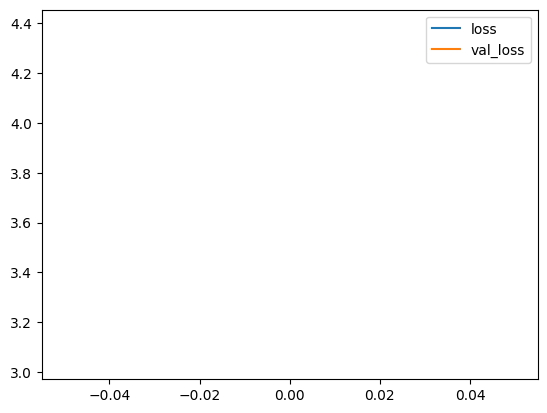

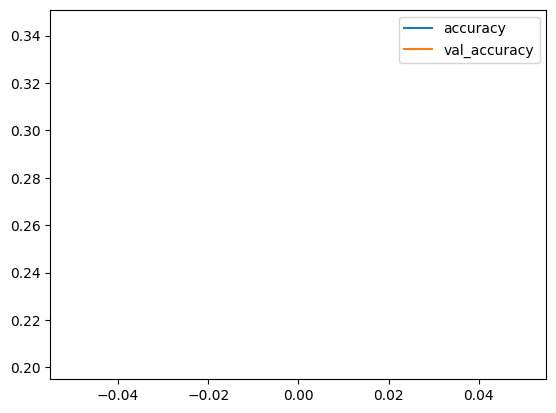

In [76]:
model = partial(partial(getProtCNN, n_families_of_interest))
train_network(model, os.path.join("/content","drive","MyDrive","datasets","kaggling","pfam", "models", "protCNN_asd.h5"), epochs=1)

## Experiment 2

In [ ]:
model = partial(partial(getProtCNN, numclass=n_families_of_interest, residuals_ks=5))
train_network(model, os.path.join("/content","drive","MyDrive","datasets","kaggling","pfam", "models", "protCNN_ks=5.h5"), epochs=25)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 512, 25)      625         ['input_8[0][0]']                
                                                                                                  
 permute_14 (Permute)           (None, 25, 512)      0           ['embedding_7[0][0]']            
                                                                                                  
 conv1d_70 (Conv1D)             (None, 25, 64)       262208      ['permute_14[0][0]']             
                                                                                            

## Experiment 3

In [ ]:
model = partial(partial(getProtCNN, numclass=n_families_of_interest, residuals_ks=7, residuals_filters=128))
train_network(model, os.path.join("/content","drive","MyDrive","datasets","kaggling","pfam", "models", "protCNN_ks=8_rs=128.h5"), epochs=25)